# Nonlinear Least Squares demo: Navigation

Borrowed from L.Vandenberghe, UCLA, EE133A

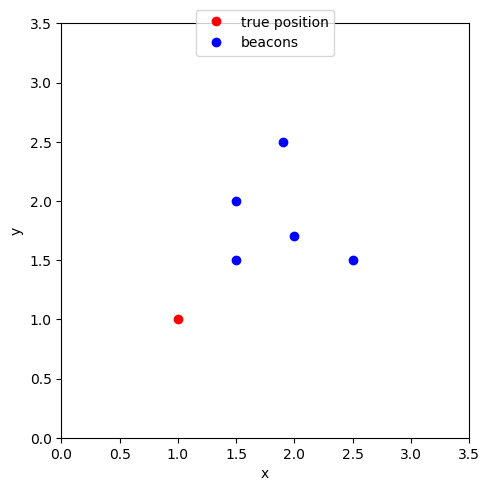

In [2]:
srand(1)

locs = [ 1.5  1.5
         1.5  2.0
         1.9  2.5
         2.0  1.7
         2.5  1.5 ]

n = size(locs,1)

truepos = [ 1.0  1.0 ]

# generate measurements
ymeas = sqrt.( sum( (locs - ones(n,1)*truepos).^2, 2 ) ) #+ .4*(randn(1)[1] - 0.5)  # can add noise

using PyPlot
figure(figsize=[5,5])
plot( truepos[1], truepos[2], "ro", label="true position" )
plot( locs[:,1], locs[:,2], "bo", label="beacons")
legend(numpoints=1,loc="upper center", bbox_to_anchor=(0.5, 1.05))
axis([0,3.5,0,3.5]); xlabel("x"); ylabel("y"); tight_layout();
#savefig("NLS_beacons.pdf")

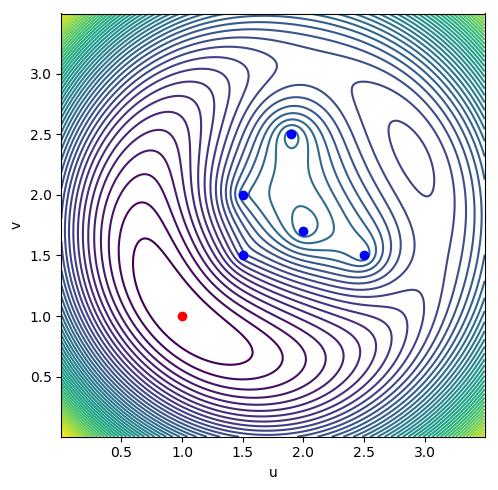

In [3]:
xv = linspace(0,3.5,351)
yv = linspace(0,3.5,351)

# swap x and y to obtain standard coordinates
res = [ sum((sqrt.(sum((locs - ones(n,1)*[x y]).^2, 2)) - ymeas).^2) for y in yv, x in xv ];

pygui(false)
figure(figsize=(6,5))
contour( res, origin="lower", extent=(0,3.5,0,3.5), 60, )
plot( locs[:,1], locs[:,2], "bo" )
plot( truepos[1], truepos[2], "ro" )
axis("image"); xlabel("u"); ylabel("v")
#colorbar()
tight_layout();
#savefig("NLS_contour.pdf")

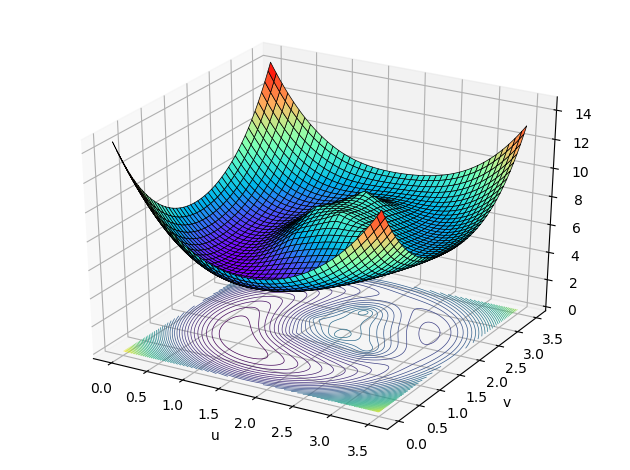

In [11]:
function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repmat(vx, m, 1), repmat(vy, 1, n))
end
(X,Y) = meshgrid(xv,yv);

pygui(false)
surf(X,Y, res+5, rstride=8, cstride=8,cmap="rainbow",edgecolor="black", linewidths=.5)
contour(X, Y, res, zdir="z", 60, offset=0, origin="lower", linewidths=.5 )
xlabel("u"); ylabel("v");
tight_layout()
#savefig("NLS_surface.pdf")

In [291]:
# show in a pop-out window instead
pygui(true)
surf(X,Y, res+5, rstride=8, cstride=8,cmap="rainbow")
contour(X, Y, res, zdir="z", 60, offset=0, origin="lower" )
xlabel("x"); ylabel("y");

## Solve using JuMP

In [14]:
using JuMP, Ipopt

m = Model(solver = IpoptSolver(print_level=0))
@variable(m, x)
@variable(m, y)
@NLexpression(m, dist[i=1:5], sqrt( (locs[i,1]-x)^2 + (locs[i,2]-y)^2 ) ) 
@NLobjective(m, Min, sum( (dist[i] - ymeas[i])^2 for i=1:5 ) )


# depending on the start value, we can converge to different local minima
# e.g. (0,0) --> global minimum, (3,3) --> local minimum

setvalue(x, 0)
setvalue(y, 0)

solve(m)

println(getvalue([x y]))
println(getobjectivevalue(m))

[1.0 1.0]
3.522111210944996e-24
